In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
train_df = pd.read_csv('train.csv', header=None)
test_df = pd.read_csv('test.csv', header=None)

In [3]:
columns = [f'Pixel-{index}' for index in range(1, 193)]
columns.append('Class-Label')

train_df.columns = columns
test_df.columns = columns

In [4]:
train_df.head()

,Pixel-1,Pixel-2,Pixel-3,Pixel-4,Pixel-5,Pixel-6,Pixel-7,Pixel-8,Pixel-9,Pixel-10,...,Pixel-184,Pixel-185,Pixel-186,Pixel-187,Pixel-188,Pixel-189,Pixel-190,Pixel-191,Pixel-192,Class-Label
0,0,0,1,1,0,0,0,0,0,0,...,0,2,2,0,0,0,0,0,0,6
1,0,0,0,0,0,0,0,0,0,0,...,4,3,0,0,0,0,0,0,0,4
2,0,0,0,0,0,2,2,0,0,0,...,0,4,2,0,0,0,0,0,0,9
3,0,0,0,0,2,4,2,0,0,0,...,0,0,0,0,2,0,0,0,0,8
4,0,0,0,1,4,4,1,0,0,0,...,2,2,2,0,0,0,0,0,0,8


In [5]:
test_df.head()

,Pixel-1,Pixel-2,Pixel-3,Pixel-4,Pixel-5,Pixel-6,Pixel-7,Pixel-8,Pixel-9,Pixel-10,...,Pixel-184,Pixel-185,Pixel-186,Pixel-187,Pixel-188,Pixel-189,Pixel-190,Pixel-191,Pixel-192,Class-Label
0,0,0,0,0,0,2,2,0,0,0,...,0,0,0,4,0,0,0,0,0,9
1,0,0,1,4,4,4,4,0,0,0,...,2,1,0,0,0,0,0,0,0,2
2,0,0,0,0,0,1,2,0,0,0,...,0,0,4,0,0,0,0,0,0,9
3,0,0,0,0,4,4,4,4,0,0,...,0,0,0,4,0,0,0,0,0,7
4,0,0,0,3,2,0,0,3,2,0,...,0,4,0,0,0,0,0,0,0,4


In [6]:
X_train, y_train = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
X_test, y_test = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

print(f'Shape of the train data : {X_train.shape}\nShape of train labels : {y_train.shape}')
print(f'Shape of the test data : {X_test.shape}\nShape of test labels : {y_test.shape}')

Shape of the train data : (6669, 192)
Shape of train labels : (6669,)
Shape of the test data : (3332, 192)
Shape of test labels : (3332,)


# Softmax Regression

## Instead of training K One-Vs-All logistic regression classifiers, we do the same implicitly.

### This can be achieved because the weight vector(array in this case) can be thought of using K vectors that are each weights trained from One-Vs-All logistic regression classification

#### So in a general logistic regression the weight vector is of shape : `(n, 1)` or simply `(n, )`
#### But incase of softmax regression the weight vector(array in this case) is of shape : `(n, k)` k=> number of classes

In [7]:
from keras.utils import to_categorical


def softmax(array: np.ndarray):
    softmax_out = np.exp(array)
    softmax_out = softmax_out / np.sum(softmax_out, axis=1, keepdims=True)
    assert np.allclose(np.sum(softmax_out), array.shape[0])
    return softmax_out



class SoftmaxRegression:
    def __init__(self):
        self.X = None  # Feature vectors [shape = (m, n)]
        self.y = None  # Class labels [shape = (m, 1) => (m, k)]
        self.W = None  # Weights [shape = (n, k)]
        self.biases = None  # Biases [shape = (k, 1)]
        self.lr = None  # Learning rate
        self.m = None
        self.n = None
        self.epochs = None
        print('Softmax Regression initialized')

    def fit(self, X: np.ndarray, y: np.ndarray, epochs: int = 50,
            use_bias: bool = True, lr: float = 0.02, verbose: bool = True):
        self.X = X
        (self.m, self.n) = X.shape  # Getting the dimensions X
        assert y.shape == (self.m, 1) or y.shape == (1, self.m) or y.shape == (self.m,)
        self.y = to_categorical(y)  # Converting labels to one-hot vectors / categorical vectors
        num_classes = np.unique(y).size  # Inferring the number of classes
        assert self.y.shape == (self.m, num_classes)
        self.W = np.random.randn(self.n, num_classes) * 0.01  # Initialising weights
        if use_bias:  # If configured to use bias
            self.biases = np.zeros((1, num_classes))  # Initialising biases
            print('Using Biases')
        self.epochs = epochs
        self.lr = lr
        return self.minimize(verbose)  # Gradient Descent to optimize for loss

    def minimize(self, verbose: bool):
        loss_hist = []
        accuracy_hist = []
        for num_epoch in tqdm(range(self.epochs)):  
            # Logits sure is an overloaded term but it seemed to fit best here
            logits = np.dot(self.X, self.W)  # Z = X · W
            if self.biases is not None:  # If configured to use biases
                logits = logits + self.biases  # Adding the biases to the logits
            predictions = softmax(logits)  # Softmax activation on the logits
            assert predictions.shape == self.y.shape
            # CrossEntropyLoss = (-1/m) * (y * log(predictions))
            loss = (-1 / self.m) * np.sum(self.y * np.log(predictions))
            # Gradient of `W` wrt the cost function
            grad_W = np.dot(self.X.T, (predictions - self.y)) / self.m
            if self.biases is not None:
                grad_b = np.sum((predictions - self.y), axis=0, keepdims=True) / self.m  # Gradient of biases
                assert self.biases.shape == grad_b.shape
                self.biases = self.biases - (self.lr) * grad_b  # Updating the biases
            assert self.W.shape == grad_W.shape
            self.W = self.W - (self.lr) * grad_W  # Updating the weights
            accuracy = self.get_accuracy(predictions, self.y)  # Computing the accuracy
            if verbose:  # If verbose is set tot True
                print(f'Epoch : {num_epoch+1}/{self.epochs}\tAccuracy : {accuracy}\tLoss Values : {loss:.4f}')
            loss_hist.append(loss)
            accuracy_hist.append(accuracy)
        return dict(loss=loss_hist, acc=accuracy_hist)
            
    def predict(self, X: np.ndarray):
        logits = np.dot(X, self.W)
        if self.biases is not None:
            logits = logits + self.biases
        return softmax(logits)
    
    def get_accuracy(self, predictions: np.ndarray, y_sample: np.ndarray):
        flattened_labels = np.argmax(y_sample, axis=1)
        flattened_predictions = np.argmax(predictions, axis=1)
        assert flattened_labels.shape == flattened_predictions.shape
        return np.mean(flattened_labels == flattened_predictions)
    
    def evaluate(self, X_sample: np.ndarray, y_sample:np.ndarray):
        predictions = self.predict(X_sample)
        y_sample = to_categorical(y_sample)
        loss = (-1 / self.m) * np.sum(y_sample * np.log(predictions))
        accuracy = self.get_accuracy(predictions, y_sample)
        return accuracy, loss

In [8]:
softmax_regression = SoftmaxRegression()
history = softmax_regression.fit(X_train, y_train, 150, True, 0.1, False)

Softmax Regression initialized
Using Biases


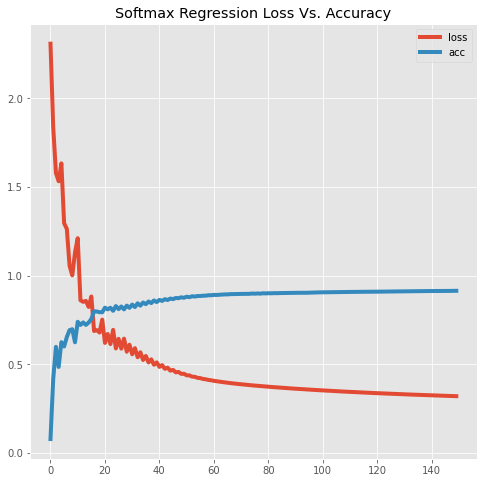

In [9]:
df = pd.DataFrame(history)
fig = df.plot(y=['loss', 'acc'], figsize=(8, 8), lw=4, title='Softmax Regression Loss Vs. Accuracy').get_figure()

# fig.savefig('Plots/SoftmaxRegressionLoss.jpeg', dpi=100, quality=95, bbox_inches = 'tight', pad_inches = 0.25)

In [10]:
softmax_regression.evaluate(X_test, y_test)

(0.9018607442977191, 0.17874681733329342)

In [11]:
test_predictions = softmax_regression.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

In [12]:
test_predictions.shape

(3332,)

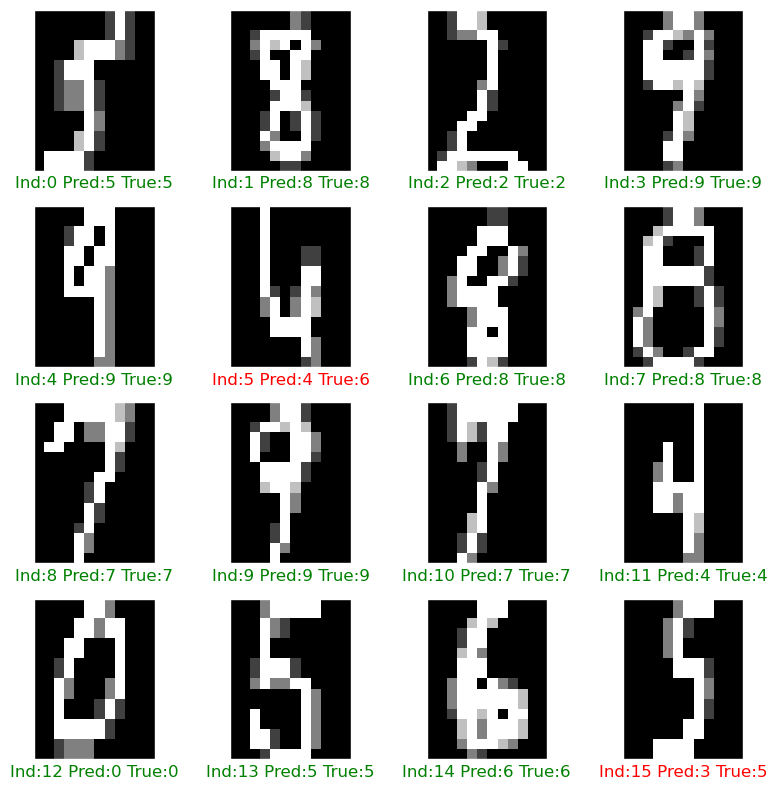

In [13]:
plt.figure(figsize=(8, 8), dpi=100)
start_index = 50

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    prediction = test_predictions[start_index + i]
    true_label = y_test[start_index + i]
    col = 'g' if prediction == true_label else 'r'
    plt.xlabel(f'Ind:{i} Pred:{prediction} True:{true_label}', color=col)
    plt.imshow(np.reshape(X_test[start_index + i], (16, 12)), cmap='gray')

plt.tight_layout()
# plt.savefig('Plots/SoftmaxRegressionPredictions.jpeg', dpi=100, quality=95)

Predicted : 3, TrueLabel : 5


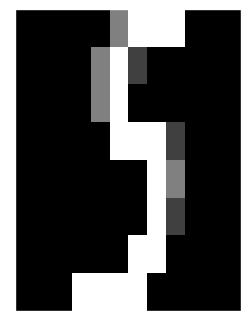

In [14]:
index = 65
sample_image = X_test[index][..., np.newaxis].T
prediction = softmax_regression.predict(sample_image)
true_label = y_test[index]

print(f'Predicted : {np.argmax(prediction)}, TrueLabel : {true_label}')

plt.figure(figsize=(6, 4), dpi=100)
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(np.reshape(sample_image, (16, 12)), cmap='gray')

Text(1.8, -0.2, 'True label : 5, Predicted : 3')

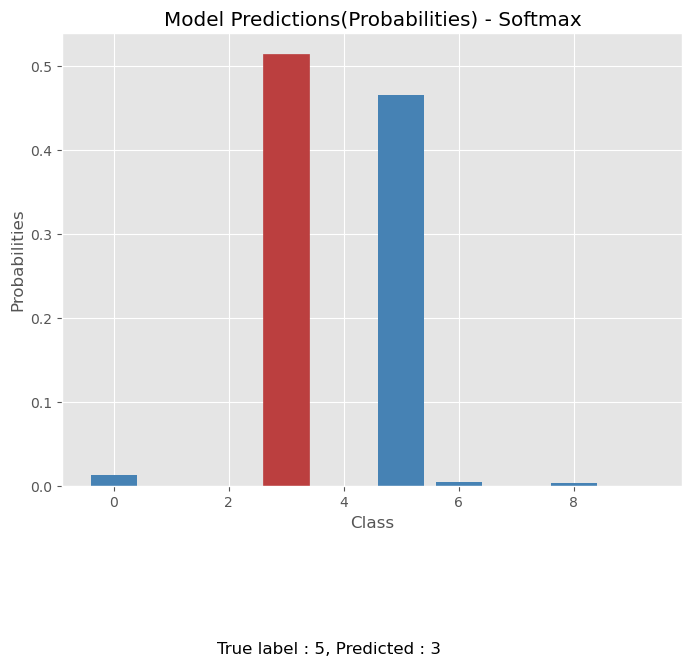

In [15]:
plt.figure(figsize=(8, 6), dpi=100)
bars = plt.bar(list(range(10)), np.squeeze(prediction), color='#4682b4')

bars[np.argmax(prediction)].set_color('#bb3f3f')

plt.title('Model Predictions(Probabilities) - Softmax')
plt.xlabel('Class')
plt.ylabel('Probabilities')
plt.text(1.8, -0.2, f'True label : {true_label}, Predicted : {np.argmax(prediction)}', fontsize=12)

# plt.savefig('Plots/SoftmaxSinglePrediction.jpeg', dpi=100, quality=95)

In [16]:
df['loss']

0      2.308969
1      1.838934
2      1.579710
3      1.532744
4      1.633748
         ...   
145    0.322808
146    0.322291
147    0.321780
148    0.321273
149    0.320771
Name: loss, Length: 150, dtype: float64

In [18]:
df['acc']

0      0.079022
1      0.417754
2      0.599040
3      0.485680
4      0.625281
         ...   
145    0.914380
146    0.914380
147    0.914680
148    0.914830
149    0.915130
Name: acc, Length: 150, dtype: float64